# Breast Cancer Classification

Breast cancer is the second most common cancer in women and men worldwide.

Breast cancer starts when cells in the breast begin to grow out of control. These cells usually form a tumor that can often be seen on an x-ray or felt as a lump. The tumor is malignant (cancer) if the cells can grow into (invade) surrounding tissues or spread (metastasize) to distant areas of the body.

## Importing Libraries

In [1]:
import os
import shutil
import json
import math

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline



# Data

The dataset can be downloaded from https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/.

This is a binary classification problem. The data is split into train/test using the below script:


In [2]:
def create_folds_from_ds(dst_path='data'):
    """Creates a structure of directories containing images
        selected from BreaKHis_v1 dataset. 2,3,4,5
    """
    root_dir = 'BreaKHis_v1/histology_slides/breast'
    srcfiles = {'DC': '%s/malignant/SOB/ductal_carcinoma/%s/%sX/%s',
                'LC': '%s/malignant/SOB/lobular_carcinoma/%s/%sX/%s',
                'MC': '%s/malignant/SOB/mucinous_carcinoma/%s/%sX/%s',
                'PC': '%s/malignant/SOB/papillary_carcinoma/%s/%sX/%s',
                'A': '%s/benign/SOB/adenosis/%s/%sX/%s',
                'F': '%s/benign/SOB/fibroadenoma/%s/%sX/%s',
                'PT': '%s/benign/SOB/phyllodes_tumor/%s/%sX/%s',
                'TA': '%s/benign/SOB/tubular_adenoma/%s/%sX/%s'}

    
    # directory for nth-fold
    dst_dir = dst_path
    if not os.path.exists(dst_dir):
        os.mkdir(dst_dir)

    # image list
    db = open('load_files.txt')
    benign_train = 0
    malignant_train = 0
    
    benign_test = 0
    malignant_test = 0
    
    for row in db.readlines():
        columns = row.split('|')
        imgname = columns[0]
        types = imgname.split('_')[1]
        if types == 'B':
            category = 'benign'
        elif types == 'M':
            category = 'malignant'
        mag = columns[1]  # 40, 100, 200, or 400
        grp = columns[3].strip()  # train or test
        
        dst_subdir = dst_dir + '/' + grp
        if not os.path.exists(dst_subdir):
            os.mkdir(dst_subdir)
        
        dst_subdir = dst_subdir + '/' + category
        if not os.path.exists(dst_subdir):
            os.mkdir(dst_subdir)
            
        tumor = imgname.split('-')[0].split('_')[-1]
        srcfile = srcfiles[tumor]
        
        s = imgname.split('-')
        sub = s[0] + '_' + s[1] + '-' + s[2]
        
        srcfile = srcfile % (root_dir, sub, mag, imgname)
        
        dstfile = dst_subdir + '/' + imgname
        
        if grp == 'train' and category == 'benign':
            if benign_train >= 250:
                continue
            else:
                benign_train +=1 
        
        if grp == 'train' and category == 'malignant':
            if malignant_train >= 250:
                continue
            else:
                malignant_train +=1
        
        if grp == 'test' and category == 'benign':
            if benign_test >= 250:
                continue
            else:
                benign_test +=1
        
        if grp == 'test' and category == 'malignant':
            if malignant_test >= 250:
                continue
            else:
                malignant_test +=1
            
        print ("Copying from [%s] to [%s]" % (srcfile, dstfile))
        shutil.copy(srcfile, dstfile)
    print('\n\n\t\t Train/Test Data Creation finished.\n')
    db.close()
    print ("\nProcess completed.")

In [3]:
create_folds_from_ds()

Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png] to [data/train/benign/SOB_B_A-14-22549AB-100-001.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png] to [data/train/benign/SOB_B_A-14-22549AB-100-002.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-003.png] to [data/train/benign/SOB_B_A-14-22549AB-100-003.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png] to [data/train/benign/SOB_B_A-14-22549AB-100-004.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-005.png] to [data/train/benign/SOB_B_A-14-22549AB-100-005.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_

Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-026.png] to [data/train/benign/SOB_B_A-14-22549AB-40-026.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-027.png] to [data/train/benign/SOB_B_A-14-22549AB-40-027.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-028.png] to [data/train/benign/SOB_B_A-14-22549AB-40-028.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-029.png] to [data/train/benign/SOB_B_A-14-22549AB-40-029.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB-400-001.png] to [data/train/benign/SOB_B_A-14-22549AB-400-001.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/400X/SOB_B_A-14-22549AB

Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-024.png] to [data/train/benign/SOB_B_A-14-22549CD-200-024.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-025.png] to [data/train/benign/SOB_B_A-14-22549CD-200-025.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-026.png] to [data/train/benign/SOB_B_A-14-22549CD-200-026.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-027.png] to [data/train/benign/SOB_B_A-14-22549CD-200-027.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-028.png] to [data/train/benign/SOB_B_A-14-22549CD-200-028.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_

Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-001.png] to [data/train/malignant/SOB_M_DC-14-10926-100-001.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-002.png] to [data/train/malignant/SOB_M_DC-14-10926-100-002.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-003.png] to [data/train/malignant/SOB_M_DC-14-10926-100-003.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-004.png] to [data/train/malignant/SOB_M_DC-14-10926-100-004.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-10926/100X/SOB_M_DC-14-10926-100-005.png] to [data/train/malignant/SOB_M_DC-14-10926-100-005.png]
Copying from [BreaKHis_v1/histology_slides/br

Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-001.png] to [data/train/malignant/SOB_M_DC-14-11031-400-001.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-002.png] to [data/train/malignant/SOB_M_DC-14-11031-400-002.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-003.png] to [data/train/malignant/SOB_M_DC-14-11031-400-003.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-004.png] to [data/train/malignant/SOB_M_DC-14-11031-400-004.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11031/400X/SOB_M_DC-14-11031-400-005.png] to [data/train/malignant/SOB_M_DC-14-11031-400-005.png]
Copying from [BreaKHis_v1/histology_slides/br

Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-014.png] to [data/train/malignant/SOB_M_DC-14-12312-200-014.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-015.png] to [data/train/malignant/SOB_M_DC-14-12312-200-015.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-016.png] to [data/train/malignant/SOB_M_DC-14-12312-200-016.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-017.png] to [data/train/malignant/SOB_M_DC-14-12312-200-017.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/200X/SOB_M_DC-14-12312-200-018.png] to [data/train/malignant/SOB_M_DC-14-12312-200-018.png]
Copying from [BreaKHis_v1/histology_slides/br

Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-029.png] to [data/train/malignant/SOB_M_DC-14-12312-400-029.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-030.png] to [data/train/malignant/SOB_M_DC-14-12312-400-030.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-031.png] to [data/train/malignant/SOB_M_DC-14-12312-400-031.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-032.png] to [data/train/malignant/SOB_M_DC-14-12312-400-032.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/400X/SOB_M_DC-14-12312-400-033.png] to [data/train/malignant/SOB_M_DC-14-12312-400-033.png]
Copying from [BreaKHis_v1/histology_slides/br

Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-010.png] to [data/test/benign/SOB_B_A-14-22549G-40-010.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-011.png] to [data/test/benign/SOB_B_A-14-22549G-40-011.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-012.png] to [data/test/benign/SOB_B_A-14-22549G-40-012.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-013.png] to [data/test/benign/SOB_B_A-14-22549G-40-013.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-014.png] to [data/test/benign/SOB_B_A-14-22549G-40-014.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/40X/SOB_B_A-14-22549G-40-015.png] to [data/test

Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-009.png] to [data/test/benign/SOB_B_A-14-29960CD-200-009.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-010.png] to [data/test/benign/SOB_B_A-14-29960CD-200-010.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-011.png] to [data/test/benign/SOB_B_A-14-29960CD-200-011.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-012.png] to [data/test/benign/SOB_B_A-14-29960CD-200-012.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-013.png] to [data/test/benign/SOB_B_A-14-29960CD-200-013.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-

Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-010.png] to [data/test/benign/SOB_B_F-14-21998CD-200-010.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-011.png] to [data/test/benign/SOB_B_F-14-21998CD-200-011.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-012.png] to [data/test/benign/SOB_B_F-14-21998CD-200-012.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-013.png] to [data/test/benign/SOB_B_F-14-21998CD-200-013.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-21998CD/200X/SOB_B_F-14-21998CD-200-014.png] to [data/test/benign/SOB_B_F-14-21998CD-200-014.png]
Copying from [BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma/SOB_B_F_14-

Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-010.png] to [data/test/malignant/SOB_M_DC-14-11520-200-010.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-011.png] to [data/test/malignant/SOB_M_DC-14-11520-200-011.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-012.png] to [data/test/malignant/SOB_M_DC-14-11520-200-012.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-013.png] to [data/test/malignant/SOB_M_DC-14-11520-200-013.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11520/200X/SOB_M_DC-14-11520-200-014.png] to [data/test/malignant/SOB_M_DC-14-11520-200-014.png]
Copying from [BreaKHis_v1/histology_slides/breast/

Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-016.png] to [data/test/malignant/SOB_M_DC-14-11951-100-016.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-017.png] to [data/test/malignant/SOB_M_DC-14-11951-100-017.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-018.png] to [data/test/malignant/SOB_M_DC-14-11951-100-018.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-019.png] to [data/test/malignant/SOB_M_DC-14-11951-100-019.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/100X/SOB_M_DC-14-11951-100-020.png] to [data/test/malignant/SOB_M_DC-14-11951-100-020.png]
Copying from [BreaKHis_v1/histology_slides/breast/

Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-013.png] to [data/test/malignant/SOB_M_DC-14-11951-400-013.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-014.png] to [data/test/malignant/SOB_M_DC-14-11951-400-014.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-015.png] to [data/test/malignant/SOB_M_DC-14-11951-400-015.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-016.png] to [data/test/malignant/SOB_M_DC-14-11951-400-016.png]
Copying from [BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-11951/400X/SOB_M_DC-14-11951-400-017.png] to [data/test/malignant/SOB_M_DC-14-11951-400-017.png]
Copying from [BreaKHis_v1/histology_slides/breast/



		 Train/Test Data Creation finished.


Process completed.


load the images in the respective folders

In [4]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('data/train/benign',224))
malign_train = np.array(Dataset_loader('data/train/malignant',224))
benign_test = np.array(Dataset_loader('data/test/benign',224))
malign_test = np.array(Dataset_loader('data/test/malignant',224))

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:02<00:00, 92.73it/s]


Creating a numpy array of zeroes for labeling benign images and similarly a numpy array of ones for labeling malignant images. Also shuffled the dataset and converted the labels into categorical format.

In [5]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Test split
split the data-set into two sets — train and test sets with 80% and 20% images respectively

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images
Display first 15 images of moles, and how they are classified


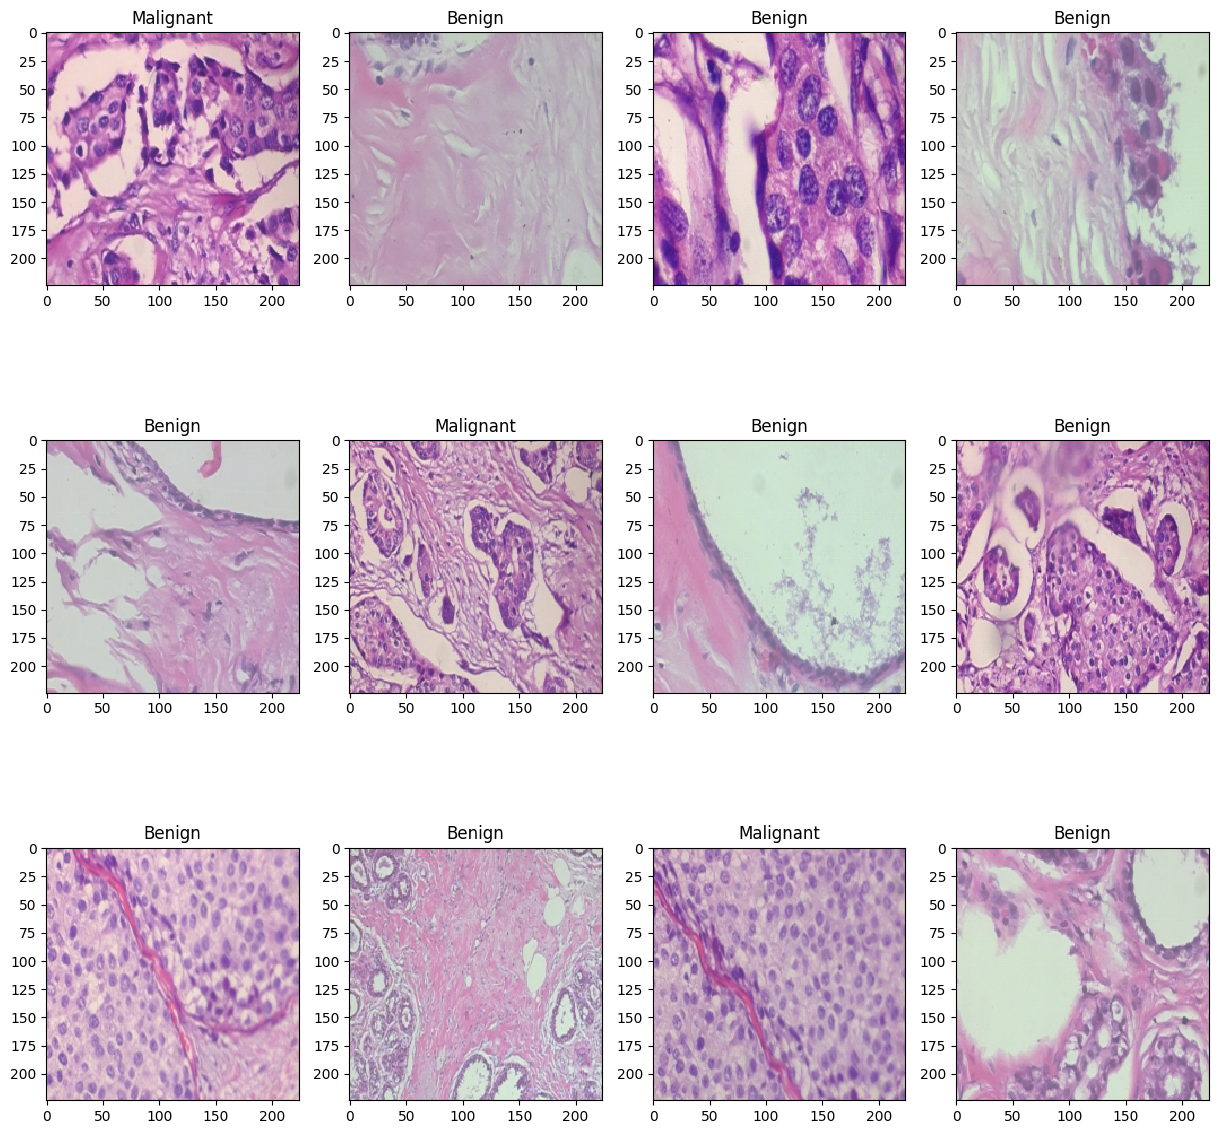

In [7]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

The practice of data augmentation is an effective way to increase the size of the training set. Augmenting the training examples allow the network to see more diversified, but still representative data points during training.
data generator to get the data from our folders and into Keras in an automated way.


In [8]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model

- I used DenseNet201 as the pre trained weights which is already trained in the Imagenet competition. The learning rate was chosen to be 0.0001.
- On top of it I used a globalaveragepooling layer followed by 50% dropouts to reduce over-fitting.
- I used batch normalization and a dense layer with 2 neurons for 2 output classes ie benign and malignant with softmax as the activation function.
- I have used Adam as the optimizer and binary-cross-entropy as the loss function.

In [9]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [10]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (Batch  (None, 1920)              7680      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18333506 (69.94 MB)
Trainable params: 1810

In [15]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [16]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
25/25 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9775
Epoch 1: val_accuracy improved from -inf to 0.46000, saving model to weights.best.hdf5


C:\Users\abdul\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 197s 8s/step - loss: 0.0563 - accuracy: 0.9775 - val_loss: 14.8035 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 2/20
25/25 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9750
Epoch 2: val_accuracy improved from 0.46000 to 0.82000, saving model to weights.best.hdf5
25/25 [==============================] - 194s 8s/step - loss: 0.0970 - accuracy: 0.9750 - val_loss: 0.5058 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 3/20
25/25 [==============================] - ETA: 0s - loss: 0.0943 - accuracy: 0.9650
Epoch 3: val_accuracy did not improve from 0.82000
25/25 [==============================] - 191s 8s/step - loss: 0.0943 - accuracy: 0.9650 - val_loss: 3.5798 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 4/20
25/25 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9775
Epoch 4: val_accuracy did not improve from 0.82000
25/25 [==============================] - 190s 8s/step - loss: 0.0717 - accuracy: 0.9775 - val_lo

In [17]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

# Performance Metrics
The most common metric for evaluating model performance is the accurcacy. However, when only 2% of your dataset is of one class (malignant) and 98% some other class (benign), misclassification scores don’t really make sense. You can be 98% accurate and still catch none of the malignant cases which could make a terrible classifier.

<Axes: >

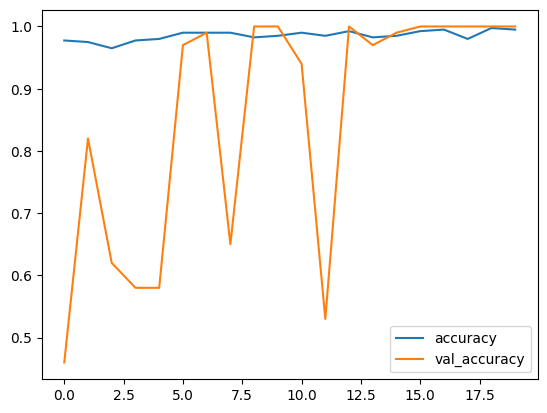

In [20]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<Axes: >

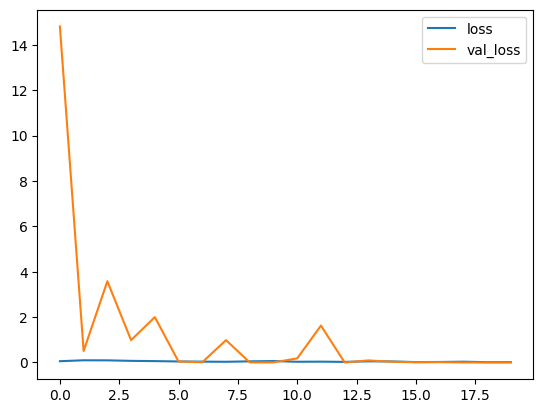

In [21]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [22]:
model.load_weights("weights.best.hdf5")

In [24]:
Y_val_pred = model.predict(x_test)

4/4 [==============================] - 12s 2s/step


In [26]:
accuracy_score(np.argmax(y_test, axis=1), np.argmax(Y_val_pred, axis=1))

1.0

In [27]:
Y_pred = model.predict(X_test)

16/16 [==============================] - 42s 3s/step


In [29]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\abdul\AppData\Local\Temp\ipykernel_6456\3759147104.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:41<00:00, 46.12s/it]


## Confusion Matrix

Confusion matrix, without normalization
[[211  39]
 [  0 250]]


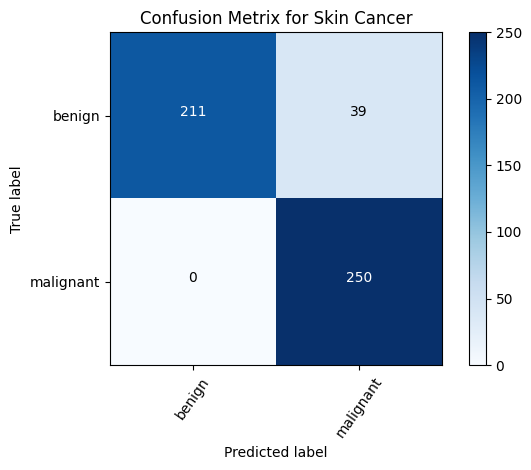

In [30]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[194  56]
 [  0 250]]


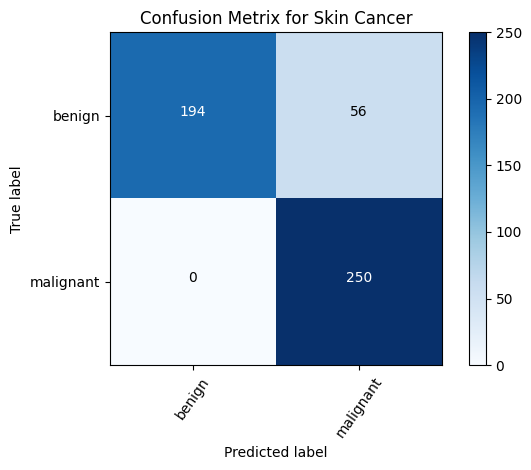

In [31]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

## Classification Report

In [32]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       1.00      0.78      0.87       250\n           1       0.82      1.00      0.90       250\n\n    accuracy                           0.89       500\n   macro avg       0.91      0.89      0.89       500\nweighted avg       0.91      0.89      0.89       500\n'

# ROC Curves

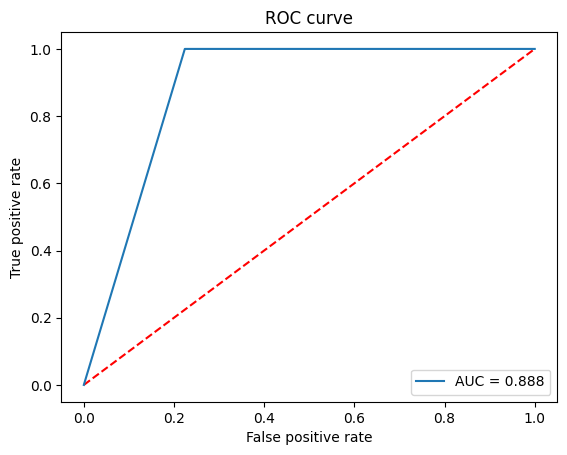

In [33]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

#### This code will display the first 8 correctly classified images from your test dataset, along with their predicted and actual labels

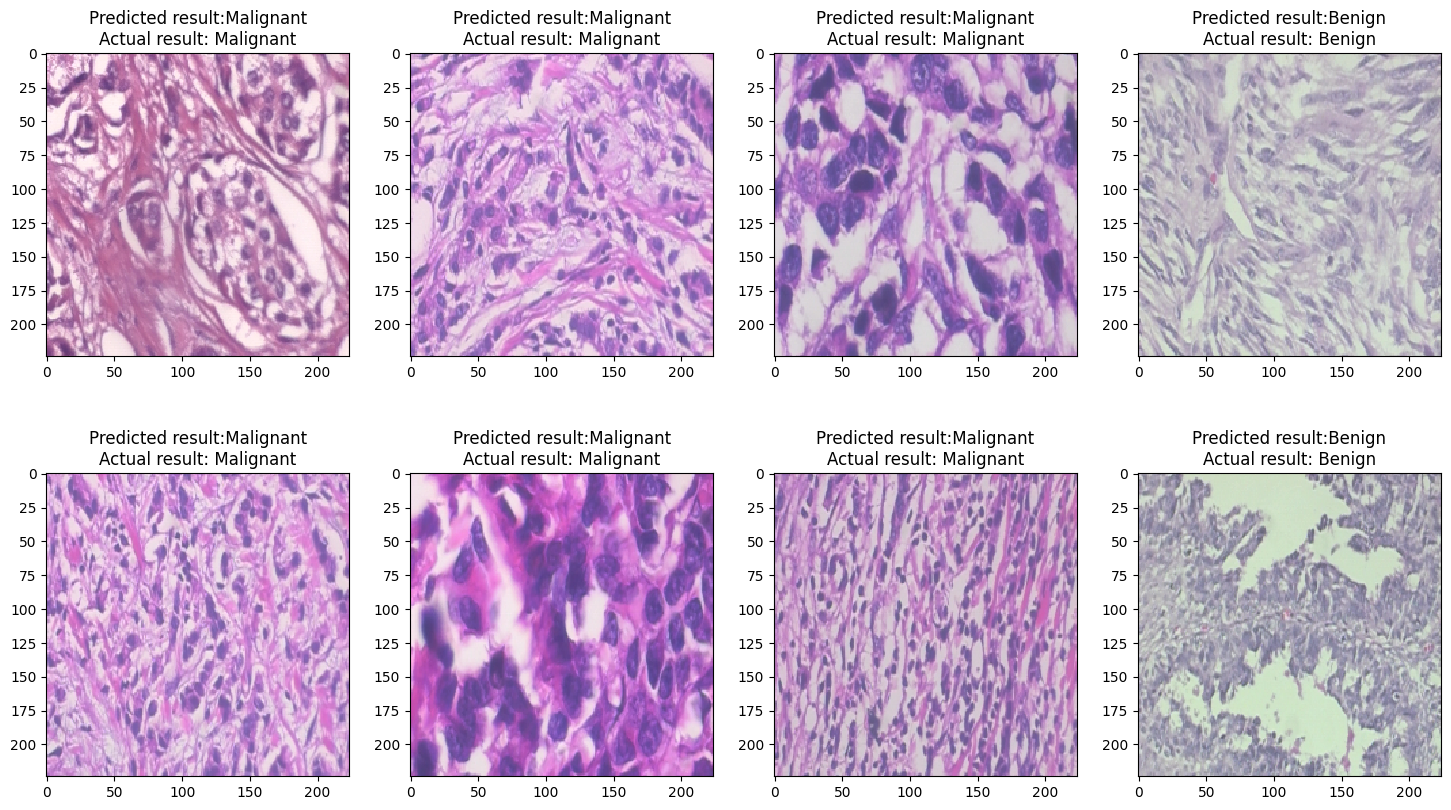

In [34]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()